In [22]:
import os
import pandas as pd
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import numpy as np

base = r"..\..\data"

def read_tb(base, filename):
    reader = SummaryReader(os.path.join(base, filename))
    df = reader.scalars
    return df

def get_data_array(df, tag):
    return df[df.tag.str.contains(tag)]['value'].to_numpy().squeeze()

def filter_df(df):
    return get_data_array(df, 'Eval_AverageReturn'), get_data_array(df, 'Eval_StdReturn')

def tags_df(df):
    return df['tag'].unique()

## Problem 1: supervised training of dynamics model

Goal: train $f_\theta(s_t, a_t) = Normalize(\Delta s_t)$.

Method:

* Real rollouts by random policy.
* $\arg\min_\theta MSE(f_\theta(s_t, a_t), Normalize(\Delta s_t))$.
* visualize the resulting predictions.

```
python cs285/scripts/run_hw4_mb.py --exp_name q1_cheetah_n500_arch1x32 --env_name cheetah-cs285-v0 --add_sl_noise --n_iter 1 --batch_size_initial 20000 --num_agent_train_steps_per_iter 500 --n_layers 1 --size 32 --scalar_log_freq -1 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q1_cheetah_n5_arch2x250 --env_name cheetah-cs285-v0 --add_sl_noise --n_iter 1 --batch_size_initial 20000 --num_agent_train_steps_per_iter 5 --n_layers 2 --size 250 --scalar_log_freq -1 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q1_cheetah_n500_arch2x250 --env_name cheetah-cs285-v0 --add_sl_noise --n_iter 1 --batch_size_initial 20000 --num_agent_train_steps_per_iter 500 --n_layers 2 --size 250 --scalar_log_freq -1 --video_log_freq -1 --mpc_action_sampling_strategy 'random'
```

Submit the generated plots.

|  | **n = 500, n_layers = 1, size = 32** | **n = 5, n_layers = 2, size = 250** | **n = 500, n_layers = 2, size = 250** |
|---|---|---|---|
| loss curve | ![](images/n500_arch1x32_itr_0_losses.png) | ![](images/n5_arch2x250_itr_0_losses.png) | ![](images/n500_arch2x250_itr_0_losses.png) |
| example predictions and mean prediction errors | ![](images/n500_arch1x32_itr_0_predictions.png) | ![](images/n5_arch2x250_itr_0_predictions.png) | ![](images/n500_arch2x250_itr_0_predictions.png) |

`(n = 500, n_layers = 2, size = 250)` gives the best loss curves, and the qualitatively closest fit between real rollouts and example rollouts. It is better than `(n = 5, n_layers = 2, size = 250)` because it is the same architecture trained for more steps (thus closer to convergence), andit is better than `(n = 500, n_layers = 1, size = 32)` because the neural network is bigger and thus has a higher capacity.

## Problem 2: Action selection by learned dynamics model and given reward function

Method:

* collect data with random policy
* train dynamics model $f_\theta$
* evaluate the MPC policy using $f_\theta$
* compare `Train AverageReturn` (from random policy) to `Eval AverageReturn` (from MPC policy).

```
python cs285/scripts/run_hw4_mb.py --exp_name q2_obstacles_singleiteration --env_name obstacles-cs285-v0 --add_sl_noise --num_agent_train_steps_per_iter 20 --n_iter 1 --batch_size_initial 5000 --batch_size 1000 --mpc_horizon 10 --video_log_freq -1 --mpc_action_sampling_strategy 'random'
```

Data put in `hw4_q2_obstacles_singleiteration_obstacles-cs285-v0_29-10-2022_11-32-38`

Expect Train AverageReturn to be around -160 and Eval AverageReturn to be around -70 to -50. Confirmed (actually, my eval return is a bit too good!): `Eval_AverageReturn : -29.98, Train_AverageReturn : -164.5`.

    step                                   tag        value
0      0                     Eval_AverageEpLen    31.153847
1      0                    Eval_AverageReturn   -29.976009
2      0                        Eval_MaxReturn    -9.469909
3      0                        Eval_MinReturn   -60.344978
4      0                        Eval_StdReturn    17.100405
5      0  Initial_DataCollection_AverageReturn  -164.489990
6      0                        TimeSinceStart     9.415771
7      0                    Train_AverageEpLen   101.000000
8      0                   Train_AverageReturn  -164.489990
9      0                   Train_EnvstepsSoFar  1010.000000
10     0                       Train_MaxReturn   -91.216759
11     0                       Train_MinReturn  -227.891647
12     0                       Train_StdReturn    42.409618
13     0                         Training_Loss     0.318721


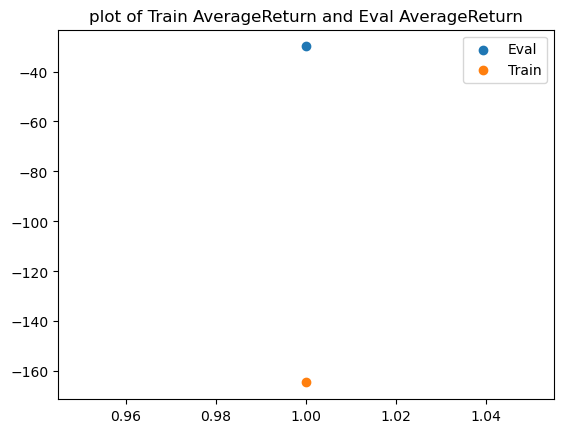

In [14]:
df = read_tb(base, 'hw4_q2_obstacles_singleiteration_obstacles-cs285-v0_29-10-2022_11-32-38')
print(df)
plt.scatter(1, get_data_array(df, 'Eval_AverageReturn'), label="Eval")
plt.scatter(1, get_data_array(df, 'Train_AverageReturn'), label="Train")
plt.title("plot of Train AverageReturn and Eval AverageReturn")
plt.legend()
plt.show()

## Problem 3: MBRL algorithm with on-policy data collection and iterative model training

```
python cs285/scripts/run_hw4_mb.py --exp_name q3_obstacles --env_name obstacles-cs285-v0 --add_sl_noise --mpc_horizon 10 --num_agent_train_steps_per_iter 20 --batch_size_initial 5000 --batch_size 1000 --n_iter 12 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q3_reacher --env_name reacher-cs285-v0 --add_sl_noise --mpc_horizon 10 --num_agent_train_steps_per_iter 1000 --batch_size_initial 5000 --batch_size 5000 --n_iter 15 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q3_cheetah --env_name cheetah-cs285-v0 --add_sl_noise --mpc_horizon 15 --num_agent_train_steps_per_iter 1500 --batch_size_initial 5000 --batch_size 5000 --n_iter 20 --video_log_freq -1 --mpc_action_sampling_strategy 'random'
```

```python
command_stem = "python cs285/scripts/run_hw4_mb.py \
--exp_name q3_{envname} --env_name {envname}-cs285-v0 --add_sl_noise \
--mpc_horizon {mpc_horizon} \
--num_agent_train_steps_per_iter {natspi} --batch_size_initial 5000 --batch_size {batch_size} --n_iter {n_iter} \
--video_log_freq -1 --mpc_action_sampling_strategy 'random'"

params = [('obstacles', 10, 20, 1000, 12), ('reacher', 10, 1000, 5000, 15), ('cheetah', 15, 1500, 5000, 20)]
```

Expect rewards and time (assuming no GPU):

| environment  | reward        | time (assuming no GPU)  |
|------------- |-------------- |------------------------ |
| obstacles    | -25 to -20    | 40 min                  |
| reacher      | -250 to -300  | 2-3 hr                  |
| cheetah      | 250 to 350    | 3-4 hr                  |

Actual performance matches very closely:

| environment  | reward        | time  |
|------------- |-------------- |------------------------ |
| obstacles    | -21    | 66 min                  |
| reacher      | -273  | 2 hr 40 min                  |
| cheetah      | 297    | 3 hr 20 min                  |

I have a GPU, but I was running 11 experiments in parallel, so that may have slowed down the time for any particular run.

Data put in

```
hw4_q3_obstacles_obstacles-cs285-v0_29-10-2022_11-45-05
hw4_q3_reacher_reacher-cs285-v0_29-10-2022_11-45-05
hw4_q3_cheetah_cheetah-cs285-v0_29-10-2022_11-45-05
```

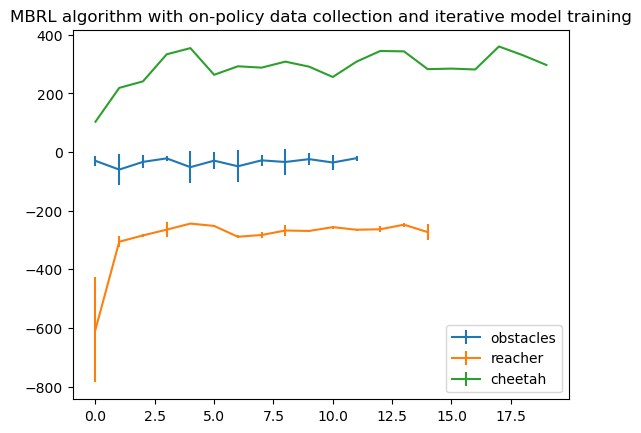

In [28]:
q3_obstacles = read_tb(base, 'hw4_q3_obstacles_obstacles-cs285-v0_29-10-2022_11-45-05')
q3_reacher = read_tb(base, 'hw4_q3_reacher_reacher-cs285-v0_29-10-2022_11-45-05')
q3_cheetah = read_tb(base, 'hw4_q3_cheetah_cheetah-cs285-v0_29-10-2022_11-45-05')

dfs = [(q3_obstacles, "obstacles"), (q3_reacher, "reacher"), (q3_cheetah, "cheetah")]
for df, label in dfs:
    xs=range(len(get_data_array(df, "Eval_AverageReturn")))
    ys=get_data_array(df, 'Eval_AverageReturn')
    yerrs=get_data_array(df, 'Eval_StdReturn')
    plt.errorbar(xs, ys, yerr=yerrs, label=label)
    
plt.title("MBRL algorithm with on-policy data collection and iterative model training")
plt.legend()
plt.show()

## Problem 4: test MBRL on 3 hyperparameters

compare the performance of your MBRL algorithm as a function of three hyperparameters:

* the number of models in your ensemble,
* the number of random action sequences considered during each action selection,
* the MPC planning horizon.

```
python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_horizon5 --env_name reacher-cs285-v0 --add_sl_noise --mpc_horizon 5 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_horizon15 --env_name reacher-cs285-v0 --add_sl_noise --mpc_horizon 15 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_horizon30 --env_name reacher-cs285-v0 --add_sl_noise --mpc_horizon 30 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_action_sampling_strategy 'random'


python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_numseq100 --env_name reacher-cs285-v0 --add_sl_noise --mpc_horizon 10 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_num_action_sequences 100 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_numseq1000 --env_name reacher-cs285-v0 --add_sl_noise --mpc_horizon 10 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_num_action_sequences 1000 --mpc_action_sampling_strategy 'random'


python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_ensemble1 --env_name reacher-cs285-v0 --ensemble_size 1 --add_sl_noise --mpc_horizon 10 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_ensemble3 --env_name reacher-cs285-v0 --ensemble_size 3 --add_sl_noise --mpc_horizon 10 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q4_reacher_ensemble5 --env_name reacher-cs285-v0 --ensemble_size 5 --add_sl_noise --mpc_horizon 10 --num_agent_train_steps_per_iter 1000 --batch_size 800 --n_iter 15 --video_log_freq -1 --mpc_action_sampling_strategy 'random'
```

Generate your plots by extracting the corresponding performance numbers from your saved tensorboard eventfiles. Use titles and legends.

Data put in

```
hw4_q4_reacher_ensemble1_reacher-cs285-v0_29-10-2022_11-46-43
hw4_q4_reacher_ensemble5_reacher-cs285-v0_29-10-2022_11-46-44
hw4_q4_reacher_ensemble3_reacher-cs285-v0_29-10-2022_11-46-44

hw4_q4_reacher_numseq100_reacher-cs285-v0_29-10-2022_11-46-44
hw4_q4_reacher_numseq1000_reacher-cs285-v0_29-10-2022_11-46-44

hw4_q4_reacher_horizon5_reacher-cs285-v0_29-10-2022_11-46-43
hw4_q4_reacher_horizon15_reacher-cs285-v0_29-10-2022_11-46-43
hw4_q4_reacher_horizon30_reacher-cs285-v0_29-10-2022_11-46-43
```

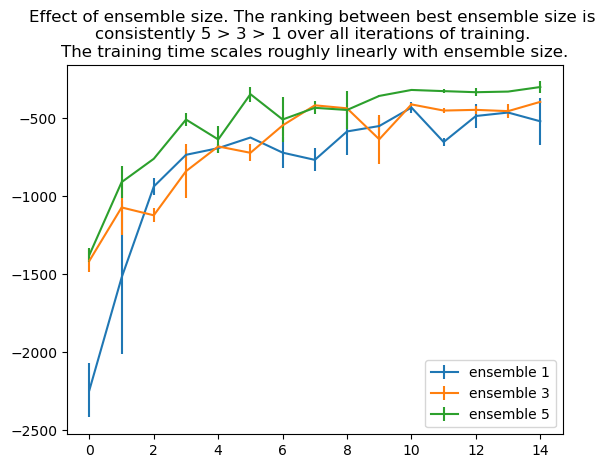

In [33]:
q4_e1 = read_tb(base, 'hw4_q4_reacher_ensemble1_reacher-cs285-v0_29-10-2022_11-46-43')
q4_e3 = read_tb(base, 'hw4_q4_reacher_ensemble3_reacher-cs285-v0_29-10-2022_11-46-44')
q4_e5 = read_tb(base, 'hw4_q4_reacher_ensemble5_reacher-cs285-v0_29-10-2022_11-46-44')

dfs = [(q4_e1, "ensemble 1"), (q4_e3, "ensemble 3"), (q4_e5, "ensemble 5")]

for df, label in dfs:
    xs=range(len(get_data_array(df, "Eval_AverageReturn")))
    ys=get_data_array(df, 'Eval_AverageReturn')
    yerrs=get_data_array(df, 'Eval_StdReturn')
    plt.errorbar(xs, ys, yerr=yerrs, label=label)

plt.title("""Effect of ensemble size. The ranking between best ensemble size is 
consistently 5 > 3 > 1 over all iterations of training. 
The training time scales roughly linearly with ensemble size.""")
plt.legend()
plt.show()

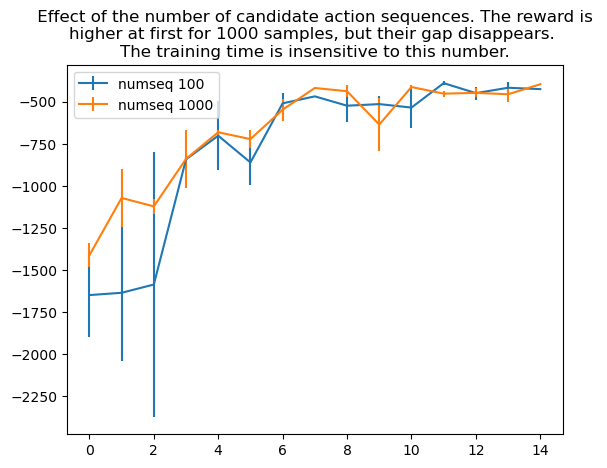

In [34]:
q4_n100 = read_tb(base, 'hw4_q4_reacher_numseq100_reacher-cs285-v0_29-10-2022_11-46-44')
q4_n1000 = read_tb(base, 'hw4_q4_reacher_numseq1000_reacher-cs285-v0_29-10-2022_11-46-44')

dfs = [(q4_n100, "numseq 100"), (q4_n1000, "numseq 1000")]

for df, label in dfs:
    xs=range(len(get_data_array(df, "Eval_AverageReturn")))
    ys=get_data_array(df, 'Eval_AverageReturn')
    yerrs=get_data_array(df, 'Eval_StdReturn')
    plt.errorbar(xs, ys, yerr=yerrs, label=label)

plt.title(""" Effect of the number of candidate action sequences. The reward is 
higher at first for 1000 samples, but their gap disappears. 
The training time is insensitive to this number.""")
plt.legend()
plt.show()

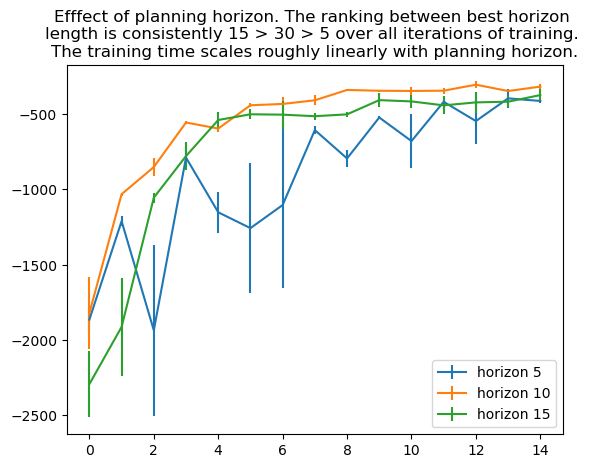

In [36]:
q4_h5 = read_tb(base, 'hw4_q4_reacher_horizon5_reacher-cs285-v0_29-10-2022_11-46-43')
q4_h10 = read_tb(base, 'hw4_q4_reacher_horizon15_reacher-cs285-v0_29-10-2022_11-46-43')
q4_h15 = read_tb(base, 'hw4_q4_reacher_horizon30_reacher-cs285-v0_29-10-2022_11-46-43')

dfs = [(q4_h5, "horizon 5"), (q4_h10, "horizon 10"), (q4_h15, "horizon 15")]

for df, label in dfs:
    xs=range(len(get_data_array(df, "Eval_AverageReturn")))
    ys=get_data_array(df, 'Eval_AverageReturn')
    yerrs=get_data_array(df, 'Eval_StdReturn')
    plt.errorbar(xs, ys, yerr=yerrs, label=label)

plt.title("""Efffect of planning horizon. The ranking between best horizon 
length is consistently 15 > 30 > 5 over all iterations of training. 
The training time scales roughly linearly with planning horizon.""")
plt.legend()
plt.show()

Summary of findings:

* The model performs better with larger ensemble than with a smaller one. 5 heads is better than 3, which is better than 1.
* The model performs better with intermediate planning horizon. Too long, and the noise in the model dominates. Too short, and the actions are short-sighted.
* The model performs about as badly with 100 random candidate action sequences as 1000. We are unclear about the reason.
* Most of the time is spent on model rollouts (which calls a neural network), rather than on evaluating trajectories (which calls much simpler arithmetic functions). This explains why the training time scales roughly linearly with ensemble size and horizon length, but is insensitive to number of candidate action sequences.

## Problem 5: Compare MBRL using random-shooting and CEM on the cheetah env

Because CEM can be much slower than random-shooting, we will only run MBRL for 5 iterations for this problem. We will try two hyperparameter settings for CEM and compare their performance to random-shooting.

```
python cs285/scripts/run_hw4_mb.py --exp_name q5_cheetah_random --env_name 'cheetah-cs285-v0' --mpc_horizon 15 --add_sl_noise --num_agent_train_steps_per_iter 1500 --batch_size_initial 5000 --batch_size 5000 --n_iter 5 --video_log_freq -1 --mpc_action_sampling_strategy 'random'

python cs285/scripts/run_hw4_mb.py --exp_name q5_cheetah_cem_2 --env_name 'cheetah-cs285-v0' --mpc_horizon 15 --add_sl_noise --num_agent_train_steps_per_iter 1500 --batch_size_initial 5000 --batch_size 5000 --n_iter 5 --video_log_freq -1 --mpc_action_sampling_strategy 'cem' --cem_iterations 2

python cs285/scripts/run_hw4_mb.py --exp_name q5_cheetah_cem_4 --env_name 'cheetah-cs285-v0' --mpc_horizon 15 --add_sl_noise --num_agent_train_steps_per_iter 1500 --batch_size_initial 5000 --batch_size 5000 --n_iter 5 --video_log_freq -1 --mpc_action_sampling_strategy 'cem' --cem_iterations 4
```

Data put in

```
hw4_q5_cheetah_random_cheetah-cs285-v0_30-10-2022_12-33-49
hw4_q5_cheetah_cem_2_cheetah-cs285-v0_30-10-2022_12-33-49
hw4_q5_cheetah_cem_4_cheetah-cs285-v0_30-10-2022_12-33-49
```

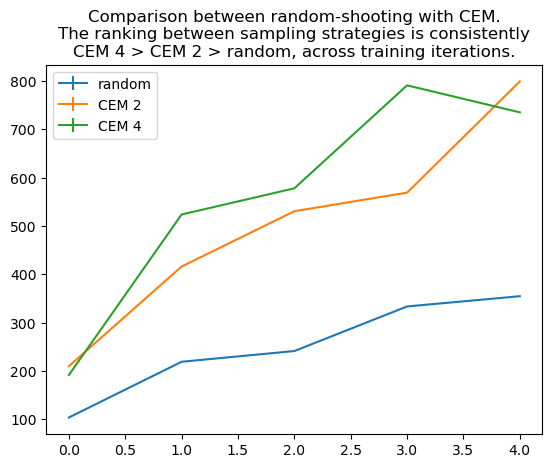

In [38]:
q5_r = read_tb(base, 'hw4_q5_cheetah_random_cheetah-cs285-v0_30-10-2022_12-33-49')
q5_cem2 = read_tb(base, 'hw4_q5_cheetah_cem_2_cheetah-cs285-v0_30-10-2022_12-33-49')
q5_cem4 = read_tb(base, 'hw4_q5_cheetah_cem_4_cheetah-cs285-v0_30-10-2022_12-33-49')


dfs = [(q5_r, "random"), (q5_cem2, "CEM 2"), (q5_cem4, "CEM 4")]

for df, label in dfs:
    xs=range(len(get_data_array(df, "Eval_AverageReturn")))
    ys=get_data_array(df, 'Eval_AverageReturn')
    yerrs=get_data_array(df, 'Eval_StdReturn')
    plt.errorbar(xs, ys, yerr=yerrs, label=label)

plt.title("""Comparison between random-shooting with CEM.
The ranking between sampling strategies is consistently
CEM 4 > CEM 2 > random, across training iterations.""")
plt.legend()
plt.show()

## Problem 6: Dyna with 10-step rollouts and SAC agent

Method: use the learned model to generate additional samples to train a SAC agent.

We will try three settings (each setting corresponds to a command below):

1. Model-free SAC baseline: no additional rollouts from the learned model.
2. Dyna: add single-step rollouts from the model to the replay buffer and incorporate additional gradient steps per real world step.
3. MBPO: add in 10-step rollouts from the model to the replay buffer and incorporate additional gradient steps per real world step.

```
python cs285/scripts/run_hw4_mbpo.py --exp_name q6_cheetah_rlen0 --env_name 'cheetah-cs285-v0' --add_sl_noise --num_agent_train_steps_per_iter 1500 --batch_size_initial 5000 --batch_size 5000 --n_iter 10 --video_log_freq -1 --sac_discount 0.99 --sac_n_layers 2 --sac_size 256 --sac_batch_size 1500 --sac_learning_rate 0.0003 --sac_init_temperature 0.1 --sac_n_iter 1000 --mbpo_rollout_length 0

python cs285/scripts/run_hw4_mbpo.py --exp_name q6_cheetah_rlen1 --env_name 'cheetah-cs285-v0' --add_sl_noise --num_agent_train_steps_per_iter 1500 --batch_size_initial 5000 --batch_size 5000 --n_iter 10 --video_log_freq -1 --sac_discount 0.99 --sac_n_layers 2 --sac_size 256 --sac_batch_size 1500 --sac_learning_rate 0.0003 --sac_init_temperature 0.1 --sac_n_iter 5000 --mbpo_rollout_length 1

python cs285/scripts/run_hw4_mbpo.py --exp_name q6_cheetah_rlen10 --env_name 'cheetah-cs285-v0' --add_sl_noise --num_agent_train_steps_per_iter 1500 --batch_size_initial 5000 --batch_size 5000 --n_iter 10 --video_log_freq -1 --sac_discount 0.99 --sac_n_layers 2 --sac_size 256 --sac_batch_size 1500 --sac_learning_rate 0.0003 --sac_init_temperature 0.1 --sac_n_iter 5000 --mbpo_rollout_length 10
```

Data put in 

```
hw4_q6_cheetah_rlen0_cheetah-cs285-v0_01-11-2022_02-22-21
hw4_q6_cheetah_rlen1_cheetah-cs285-v0_01-11-2022_02-27-56
hw4_q6_cheetah_rlen10_cheetah-cs285-v0_01-11-2022_02-31-33
```

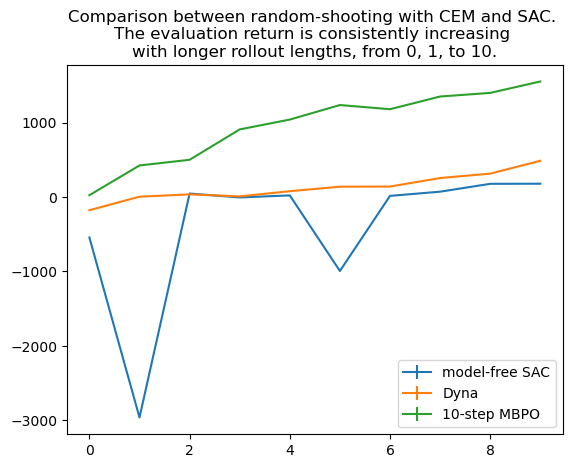

In [40]:
q6_r0 = read_tb(base, 'hw4_q6_cheetah_rlen0_cheetah-cs285-v0_01-11-2022_02-22-21')
q6_r1 = read_tb(base, 'hw4_q6_cheetah_rlen1_cheetah-cs285-v0_01-11-2022_02-27-56')
q6_r10 = read_tb(base, 'hw4_q6_cheetah_rlen10_cheetah-cs285-v0_01-11-2022_02-31-33')


dfs = [(q6_r0, "model-free SAC"), (q6_r1, "Dyna"), (q6_r10, "10-step MBPO")]
for df, label in dfs:
    xs=range(len(get_data_array(df, "Eval_AverageReturn")))
    ys=get_data_array(df, 'Eval_AverageReturn')
    yerrs=get_data_array(df, 'Eval_StdReturn')
    plt.errorbar(xs, ys, yerr=yerrs, label=label)

plt.title("""Comparison between random-shooting with CEM and SAC. 
The evaluation return is consistently increasing 
with longer rollout lengths, from 0, 1, to 10.""")
plt.legend()
plt.show()